# <center> **ПРОЕКТ "Анализ воронки вовлечения в игру"**

В нашем распоряжении имеются данные о прохождении ключевых этапов пользователями мобильной игры Quiz Freeze. Мы знаем, что одна часть этапов игры открыта для бесплатного пользования, а другая часть - может быть достпупна только после ее оплаты. Мы также знаем, что среди прочих этапов игры есть этап обучения, который, как можно предположить, помогает пользователям в достижении некоторых результатов по мере прохождения игры и таким образом влияет на заинтересован-ность пользователей в покупке ее платных пакетов.

С целью исследования полезности и эффективности этапа обучения с точки зрения удержания пользователей в игре и продвижения ее платных пакетов выдвинем несколько связанных с этапов обучения гипотез, а затем их проверим.

Гипотеза 1
По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?

Гипотеза 2
Кажется, повторное прохождение обучения положительно влияет на оплату, верно ли это?

Гипотеза 3
Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### *1. Познакомимся с данными*

In [2]:
events = pd.read_csv('events.csv', sep=',')
purchase = pd.read_csv('purchase.csv', sep=',')

events.info()
print('')
purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252334 entries, 0 to 252333
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              252334 non-null  int64  
 1   event_type      252334 non-null  object 
 2   selected_level  31086 non-null   object 
 3   start_time      252334 non-null  object 
 4   tutorial_id     125103 non-null  float64
 5   user_id         252334 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 11.6+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956 entries, 0 to 5955
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              5956 non-null   int64 
 1   user_id         5956 non-null   int64 
 2   event_datetime  5956 non-null   object
 3   amount          5956 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 186.2+ KB


In [3]:
display(events)
display(purchase)

,id,event_type,selected_level,start_time,tutorial_id,user_id
0,28903,registration,NaN,2016-05-11T23:40:55,NaN,12583
1,28904,registration,NaN,2016-05-11T23:49:58,NaN,12584
2,28905,registration,NaN,2016-05-12T00:53:07,NaN,12585
3,28906,tutorial_start,NaN,2016-05-12T01:32:20,17562.0,12585
4,28907,tutorial_finish,NaN,2016-05-12T01:34:53,17562.0,12585
...,...,...,...,...,...,...
252329,281232,level_choice,hard,2020-07-02T10:02:15,NaN,87439
252330,281233,level_choice,medium,2020-07-02T11:38:52,NaN,87488
252331,281234,pack_choice,NaN,2020-07-02T11:42:14,NaN,87488
252332,281235,tutorial_start,NaN,2020-07-02T13:32:58,86127.0,87464


,id,user_id,event_datetime,amount
0,15674,12584,2016-05-12T10:34:16,100
1,15675,12985,2016-05-13T08:25:56,50
2,15676,12828,2016-05-13T16:33:46,50
3,15677,12598,2016-05-14T01:09:37,150
4,15678,13037,2016-05-14T01:24:46,100
...,...,...,...,...
5951,21625,87331,2020-07-06T09:02:07,50
5952,21626,87418,2020-07-06T14:16:37,100
5953,21627,87431,2020-07-06T22:48:59,50
5954,21628,87363,2020-07-07T05:38:56,100


Первое общее знакомство с таблицами events и purchase показало, что таблица events содержит ячейки с пустыми значениями, а столбцы таблиц events и purchase с данными о дате и времени события, имеют тип данных - object. И тому, и другому уделим внимание дальше, при формировании датафрейма, на основании которого будут проводиться исследования, а затем внесем необходимые корректировки.


### *2. Перед началом преобразования исходных таблиц создадим их копии.*

Комментарий: в нашем случае, когда размер таблиц очевидно небольшой, выполнение данного шага можно было бы пропустить, но с целью выработки полезной привычки мы это сделаем :)

In [4]:
events_df = events.copy()
purchase_df = purchase.copy()

### *3. Объединим данные двух таблиц.*

Это необходимо, т.к. наше исслелование предполагает работу со всеми этапами игры, включая оплату, сведения о которой содержится в отдельном датасете. Непосредственно перед объединением двух таблиц проделаем с ними некоторые манипуляции, чтобы объединение прошло корректно, а именно: в таблицу purchase_df добавим столбец, заполненный значением purchase, который обозначит этап, описанный данной таблицей (purchase_df), а также некоторым столбцам таблиц присвоим новые заголовки, чтобы признаки двух объединенных таблиц продолжали корректно и эффективно нести свою смысловую нагрузку в новой таблице. А затем, после объединения таблиц в новый датафрейм,
сбросим индексы, перенесенные в него из исходных таблиц и не несущие смысла после объединения, а также отсортируем все события по возрастанию времени.

In [5]:
purchase_df['event_type'] = 'purchase'
events_df = events_df.rename(columns={"id": "event_id"})
purchase_df = purchase_df.rename(columns={"id": "purchase_id", "event_datetime":"start_time"})
total_events_df = pd.concat([events_df,purchase_df],sort=False)
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')
total_events_df

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,28903.0,registration,NaN,2016-05-11T23:40:55,NaN,12583,NaN,NaN
1,28904.0,registration,NaN,2016-05-11T23:49:58,NaN,12584,NaN,NaN
2,28905.0,registration,NaN,2016-05-12T00:53:07,NaN,12585,NaN,NaN
3,28906.0,tutorial_start,NaN,2016-05-12T01:32:20,17562.0,12585,NaN,NaN
4,28907.0,tutorial_finish,NaN,2016-05-12T01:34:53,17562.0,12585,NaN,NaN
...,...,...,...,...,...,...,...,...
258286,NaN,purchase,NaN,2020-07-06T14:16:37,NaN,87418,21626.0,100.0
258287,NaN,purchase,NaN,2020-07-06T22:48:59,NaN,87431,21627.0,50.0
258288,NaN,purchase,NaN,2020-07-07T05:38:56,NaN,87363,21628.0,100.0
258289,NaN,purchase,NaN,2020-07-08T01:59:21,NaN,87466,21629.0,50.0


### *4. Сформируем список пользователей, зарегистрированных в 2018 году.*

Примечание: Взаимодействие именно этих пользователей с игрой мы и будем изучать по условию задания.

In [6]:
mask1 = total_events_df['start_time'] >= '2018-01-01'
mask2 = total_events_df['start_time'] < '2019-01-01'
mask3 = total_events_df['event_type'] == 'registration'
user_id = total_events_df[mask1 & mask2 & mask3]['user_id']
user_id_sp = set(user_id)


### *5. Подготовим итоговую таблицу, на основании которой будем проводить наше исследование*

На основе объединенного датафрейма total_events_df получим таблицу с данными о прохождении ключевых этапов игры пользователями, зарегистрированными в 2018 году. Далее очистим полученную таблицу от строк с пустыми значениями в столбцах: user_id, start_time или event_type, а также от дублей строк (при наличии или первых, или вторых, или и тех и других вместе). Затем столбец с датой и временем приведем к формату datetime. Получим таблицу, которая станет для нас опорной: на основании данных, которые она будет содержать, мы и проведем свое исследование. Итак, получим новую таблицу и изучим общие сведения о ней.

In [7]:
total_events_df['user_id_2018'] = total_events_df['user_id'].apply(lambda x: 1 if x in user_id_sp else 0)
total_events_df_2018 = total_events_df[total_events_df['user_id_2018'] == 1]
total_events_df_2018 = total_events_df_2018.drop('user_id_2018', axis=1)

total_events_df_2018 = total_events_df_2018.drop_duplicates(ignore_index=True)
total_events_df_2018.dropna(subset = ['user_id','start_time','event_type'], axis=0)

total_events_df_2018['start_time'] = pd.to_datetime(total_events_df_2018['start_time']) 

total_events_df_2018.info()
display(total_events_df_2018)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68559 entries, 0 to 68558
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   event_id        66959 non-null  float64       
 1   event_type      68559 non-null  object        
 2   selected_level  8342 non-null   object        
 3   start_time      68559 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  float64       
 5   user_id         68559 non-null  int64         
 6   purchase_id     1600 non-null   float64       
 7   amount          1600 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 4.2+ MB


,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
...,...,...,...,...,...,...,...,...
68554,NaN,purchase,NaN,2019-01-02 03:48:19,NaN,47498,18441.0,100.0
68555,NaN,purchase,NaN,2019-01-02 23:26:26,NaN,47647,18442.0,150.0
68556,NaN,purchase,NaN,2019-01-03 00:36:36,NaN,47554,18443.0,50.0
68557,NaN,purchase,NaN,2019-01-04 12:51:41,NaN,47742,18448.0,50.0


### *6. Последний "штрих" перед началом проверки Гипотез*

Наша таблица для исследования готова, но прежде чем приступить к проверке гипотез, узнаем, какие этапы, события пользователи проходили или могли проходить не один раз, чтобы учесть возможность таких повторов в нашем исследовании.

In [8]:
print('Максимальное число обучений, начатых одним пользователем - ',
    total_events_df_2018[total_events_df_2018['event_type'] == 'tutorial_start'].groupby(
    'user_id')['event_type'].count().max())
print('Максимальное число обучений, оконченных одним пользователем - ',
    total_events_df_2018[total_events_df_2018['event_type'] == 'tutorial_finish'].groupby(
    'user_id')['event_type'].count().max())
print('Максимальное число раз выбора уровня сложности одним пользователем - ',
    total_events_df_2018[total_events_df_2018['event_type'] == 'level_choice'].groupby(
    'user_id')['event_type'].count().max())
print('Максимальное число раз выбора пакетов вопросов одним пользователем - ',
    total_events_df_2018[total_events_df_2018['event_type'] == 'pack_choice'].groupby(
    'user_id')['event_type'].count().max())
print('Максимальное число оплат одним пользователем - ',
    total_events_df_2018[total_events_df_2018['event_type'] == 'purchase'].groupby(
    'user_id')['event_type'].count().max())

Максимальное число обучений, начатых одним пользователем -  9
Максимальное число обучений, оконченных одним пользователем -  9
Максимальное число раз выбора уровня сложности одним пользователем -  1
Максимальное число раз выбора пакетов вопросов одним пользователем -  1
Максимальное число оплат одним пользователем -  1


Мы видим, что только этап обучения пользователи могли проходить и проходили не единожды. Учтем это в нашем исследовании.

### *7. Перейдем к проверке гипотез*

### *7.1. Гипотеза №1*

Напомним содержание Гипотезы. Мы предположили, что в поведении групп, которые проходят и не проходят обучение, должна быть разница. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры? Для проверки Гипотезы № 1, нам необходимо сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель для указанных групп отличается - выяснить, насколько.

Для начала разделим всех пользователей игры на три группы: 1-я группа будет состоять из тех, кто не начинал обучение, 2-я - из тех, кто начал, но не завершил обучение, 3-я - из тех, кто начал и завершил обучение. Для этого численность всех пользователей, зарегистрированных в 2018 г., разделим на пользователей, не начинавших обучение и пользователей, начинавших обучение. Последние, в свою очередь, будут включать в себя пользователей, не завершивших обучение, и пользователей, завершивших обучение. Почему мы выделяем три, а не две группы, и как мы будем с этими группами работать - выясним ниже, в ходе текущих исследований. 

Примечание: далее все маски, которые будем использовать в коде, будут выноститься в отдельные ячейки для упрощения возврата к ним (при необходимости). 

In [9]:
# маски:
mask_tutorial_start = total_events_df_2018['event_type'] == 'tutorial_start'
mask_tutorial_finish = total_events_df_2018['event_type'] == 'tutorial_finish'

In [10]:
user_id_tutorial_start = set(total_events_df_2018[mask_tutorial_start]['user_id'].unique())
user_id_tutorial_finish = set(total_events_df_2018[mask_tutorial_finish]['user_id'].unique())

user_id_tutorial_no_start = user_id_sp.difference(user_id_tutorial_start)
user_id_tutorial_start_wo_finish = user_id_tutorial_start.difference(user_id_tutorial_finish)

print('Всего пользователей, зарегистрированных в 2018 г. -',len(user_id_sp),'чел.')
print('Всего пользователей, не начинавших обучение -',len(user_id_tutorial_no_start),'чел.')
print('Всего пользователей, начавших обучение -',len(user_id_tutorial_start),'чел., в т.ч.:')
print('                     не завершивших обучение -',len(user_id_tutorial_start_wo_finish),'чел.')
print('                     завершивших обучение -',len(user_id_tutorial_finish),'чел.')

Всего пользователей, зарегистрированных в 2018 г. - 19926 чел.
Всего пользователей, не начинавших обучение - 8068 чел.
Всего пользователей, начавших обучение - 11858 чел., в т.ч.:
                     не завершивших обучение - 1608 чел.
                     завершивших обучение - 10250 чел.


Далее посмотрим на прохождение этими категориями пользователей различных этапов игры (т.е. изучим пользовательские пути взаимодействия с игрой). Это необходимо прежде всего для того, чтобы во избежание получения ошибочных выводов исключить из наших расчетов пользователей, которые пользователями игры по сути не стали. Так, среди пользователей, не начинавших обучение, мы увидим тех, кто покинул игру после регистрации в ней, так и не приступив ни к одному из последующих этапов.


Прежде чем определить пользовательские пути взаимодействия с игрой, получим перечни идентификаторов обучения (tutorial_id) из событий "начало обучения" и "окончание обучения" (tutorial_start, tutorial_finish), исключив из них дубли этих событий (повторные обучения) для каждого отдельного пользователя (мы помним, что только эти события могут повторяться, см. п.6). Перечень tutorial_id из событий tutorial_start будет включать в себя tutorial_id первых (по start_time) начатых обучений только для тех 1608 пользователей, которые ни разу не завершили обучение. Перечень tutorial_id из событий tutorial_finish будет включать в себя tutorial_id первых (по start_time) оконченных обучений для 10250 пользователей, которые завершили обучение. Примечание: в рамках провеки Гипотезы № 1 дубли начала и окончания обучений (повторные обучения) не несут никакой смысловой нагрузки (т.к. данная гипотеза не предусматривает зависимости прохождения этапов игры от количества обучений), а потому подлежат исключению.

In [11]:
# маска
mask_user_id_tutorial_start_wo_finish = total_events_df_2018['user_id'].isin(user_id_tutorial_start_wo_finish)

In [12]:
tutorial_start_wo_finish_df = total_events_df_2018[(mask_tutorial_start & mask_user_id_tutorial_start_wo_finish)]
tutorial_start_wo_finish_wo_duplicates_df = tutorial_start_wo_finish_df.sort_values("start_time").drop_duplicates("user_id")
start_wo_finish_tutorial_wo_duplicates_ids = tutorial_start_wo_finish_wo_duplicates_df["tutorial_id"].unique()

tutorial_finish_df = total_events_df_2018[mask_tutorial_finish]
tutorial_finish_wo_duplicates_df = tutorial_finish_df.sort_values("start_time").drop_duplicates("user_id")
first_finish_tutorial_wo_duplicates_ids = tutorial_finish_wo_duplicates_df["tutorial_id"].unique()

print(len(start_wo_finish_tutorial_wo_duplicates_ids))
print(len(first_finish_tutorial_wo_duplicates_ids))

start_wo_finish_tutorial_wo_duplicates_ids, first_finish_tutorial_wo_duplicates_ids

1608
10250


(array([31511., 31525., 31529., ..., 49496., 49511., 49531.]),
 array([31506., 31507., 31508., ..., 49552., 49553., 49554.]))

Далее, имея очищенные от дублей (от повторных обучений) перечни идентификаторов обучений, определим пользовательские пути взаимодействия с игрой (сортировка будет осуществляться по ключу полученной серии).

In [13]:
# маски
mask_start_wo_finish_tutorial_wo_duplicates = total_events_df_2018["tutorial_id"].isin(start_wo_finish_tutorial_wo_duplicates_ids)
mask_first_finish_tutorial_wo_duplicates = total_events_df_2018["tutorial_id"].isin(first_finish_tutorial_wo_duplicates_ids)

In [14]:
total_events_df_2018['tutorial_id']=total_events_df_2018['tutorial_id'].fillna(0)
total_events_2018_wo_tut_dupl = total_events_df_2018[
    (total_events_df_2018["tutorial_id"] == 0) |
    mask_start_wo_finish_tutorial_wo_duplicates |    
    mask_first_finish_tutorial_wo_duplicates]
user_path_df = (total_events_2018_wo_tut_dupl.groupby(["user_id"])["event_type"].apply(list).reset_index())
user_path_df["event_path"] = user_path_df["event_type"].apply(lambda x: " > ".join(x))
user_paths = (user_path_df.groupby(["event_path"])["user_id"].nunique())
user_paths

event_path
registration                                                                               7970
registration > level_choice                                                                  24
registration > level_choice > pack_choice                                                    52
registration > level_choice > pack_choice > purchase                                         22
registration > tutorial_start                                                               865
registration > tutorial_start > level_choice                                                256
registration > tutorial_start > level_choice > pack_choice                                  356
registration > tutorial_start > level_choice > pack_choice > purchase                       131
registration > tutorial_start > tutorial_finish                                            2749
registration > tutorial_start > tutorial_finish > level_choice                             2325
registration > tutorial_start

Итак, мы видим, что из всех пользователей, зарегистрированных в 2018 г. и не начинавших обучение (а таких насчитывается, как мы выяснили ранее, 8068 чел.), 7970 человек - это пользователи, которые покинули игру после регистрации, так и не приступив ни к одному из последующих этапов. Скорее всего, эти пользователи зарегистрировались, поверхностно ознакомились с продуктом, поняли, что продукт не отвечает их потребностям и ушли. И дело здесь далеко не в том, что эти пользователи не прошли обучение, ведь они даже не попытались проявить в игре хоть какую-то активность, эти пользователи просто отсеялись по каким-то причинам, не дав нам возможности сравнить их поведение в игре с поведением в игре тех пользователей, которые прошли обучение. Вопрос о наличии и размере такой группы зарегистрирвованных и отсеявшихся пользователей, скорее всего, следует отнести к специалистам, которые занимаются определением и привлечением целевой аудитории, очевидно, что содержание продукта не соответствет интересам и потребностям существенной части (около 40%) привлеченной аудитории. При этом, возможно, следует внести изменения в содержательную часть продукта, но это по-прежнему не отменяет более осмысленного подхода и тщательной работы с определением и привлечением соответствующей целевой аудитории. Таким образом, возвращаясь к группе пользователей, не начинавших обучение, поведение которых нам необходимо изучить для проверки гипотезы № 1, мы видим, что для определения численности такой группы из ее состава необходимо исключить пользователей, отсеявшихся после прохождения регистрации. Таким образом, численность группы пользователей, не начинавших обучение, будет составлять всего 98 человек (8068 - 7970). Что не идет ни в какое сравнение с численностью группы пользователей, завершивших обучение (10250 чел.). Таким образом, группу пользователей, не начинавших обучение, следует рассматривать как некоторую погрешность, а гипотезу несостоятельной, т.к. проверить ее достоверность на представленных данных не представляется возможным. Для выдвижения и проверки подобной гипотезы следовало бы использовать A/B-тестирование. Хотя, кажется, и без того, очевидным, что для пользователя этап обучения сам по себе важен и даже необходим, т.к. почти 86% пользователей из тех, кто не отсеялся после регистрации в игре, проходит обучение до конца (10250/(19926-7970)*100 = 85,7%). 

Несмотря на несостоятельность Гипотезы № 1 продолжим исследования в этих рамках с тем, чтобы выяснить, возможна ли некоторая корректировка данной гипотезы, а вместе с ней и формализованной задачи, поставленной в рамках ее исследования, которая позволила бы нам получить полезные сведения о взаимодействии пользователей с игрой.

В начале работы над гипотезой № 1 мы определили, что, на самом деле, имеем дело не с двумя, а с тремя группами: 1-я группа состоит из тех, кто не начинал обучение, 2-я - из тех, кто начал, но не завершил обучение, 3-я - из тех, кто начал и завершил обучение. Это же подтверждается на примере перечня пользовательских путей. Мы видим, что только три последовательности прохождения этапов игры заканчиваются покупкой платных пакетов с вопросами (purchase). Таким же образом определяются "границы" интересующих нас групп пользователей данного продукта. Первым этапом на этом пути всегда будет регистрация (registration), целевым - покупка (purchase). При этом не суть важно, что не все полученные последовательности заканчиваются покупкой, главное, что только три пути ведут к ней, следовательно, и пользователей можно объединить в три группы. 1-я группа идет по пути: registration > level_choice > pack_choice > purchase; 2-я - по пути: registration > tutorial_start > level_choice > pack_choice > purchase; 3-я - по пути: registration > tutorial_start > tutorial_finish > level_choice > pack_choice > purchase. При этом не все пользователи, как видим, доходят до целевого этапа покупки (purchase), но они все будут идти только по одному из трех, предложенных разработчиком продукта, вариантов пути (см. приведенные выше последовательности).

Таким образом, численность 1-й группы пользователей (не начинавших обучение) - 98 чел., 2-й группы пользователей (начавших, но не закончивших обучение) - 1608 чел. и 3-й группы пользователей (завершивших обучение) - 10250 чел. То же самое подтверждается приведенными выше последовательностями прохождения этапов игры. Численность 3-й группы также в разы превышает численность 2-й группы (в 6,4 раза). Но! Группу, которая в 6,4 раза меньше основной (1608 человек), при этом следует рассматривать, скорее, как некоторый потенциал (небольшой, но все же что-то), чем как погрешность. Поэтому немного скорректируем Гипотезу № 1, а также формализованную задачу в рамках данной гипотезы, и приступим к сравнению 2-й и 3-й групп.

Гипотеза: предположим, что в поведении групп пользователей, которые начинают, но не заканчивают (2-я группа), или начинают и заканчивают (3-я группа) обучение, должна быть разница. Так ли это? Отличается ли скорость прохождения различных этапов игры указанными группами? Формализованная задача: для проверки Гипотезы, нам необходимо сравнить время прохождения различных этапов игры пользователями, незавершившими (из тех, кто начал) и завершившими обучение. Если показатель для указанных групп отличается - выяснить, насколько.

Приступим. Для начала нам необходимо определиться с отправной точкой, т.е. с тем, какой этап следует принять за начальный для нашего исследования. Регистрацию? Начало обучения? Окончание обучения? Но мы знаем, что пользователи одной из рассматриваемых нами групп начинали, но не заканчивали обучение, следовательно, мы не можем отталкиваться от этапа окончания обучения, с тем чтобы выявить его влияние на последующий процесс. Более того, причиной разного поведения групп может оказаться не только или не столько факт оконченного или неоконченного обучениия, сколько разная ментальность, разный темперамент, разные навыки и способности пользователей из разных групп. Т.е. суть вопроса может оказаться не в том или не только в том, что на этапе обучения у какой-то группы пользователей возникли сложности с его прохождением и это негативно отразилось на их дальшем поведении, или что пользователь по какой-то причине не захотел довести процесс обучения до конца, а потому столкнулся с трудностями на следующих этапах (что мы и предполагаем, говоря о ВЛИЯНИИ обучения на поведение пользователей), но и в том, что такая группа пользователей, неокончивших обучение, могла сложиться в силу каких-то других особенностей членов этой группы (эти группы, например, могут состоять из пользователей примерно одного возраста внутри группы и разных возрастов по отношению к друг другу, могут состоять из пользователей с разными (по отношению групп друг к другу) пользовательскими навыками, разной ментальностью (например, есть люди, которые изучают инструкцию, прежде чем начать пользоваться какой-то новой вещью, а есть те, кто в них даже не заглядывает и предпочитает изучать все методом "тыка") и т.д., и, конечно, в этом случае речь не идет о ВЛИЯНИИ обучения в том смысле, в котором оно было использовано выше). Поэтому, для того чтобы нам изначально не загонять себя в какие-то нами же установленные рамки и, по-возможности, минимизировать погрешность будущих результатов и уйти от ошибкок в выводах, не будем брать за точку отсчета и начало обучения, т.к. разница в поведении может выявиться еще до начала обучения, т.е. посмотрим, для интереса, и то, как скоро пользователи одной и другой групп принимают решение о прохождении обучения. Т.о. регистрацию пользователей в игре примем за точку отсчета.

Теперь нам нужно понять, что делать со временем обучения, как учитыть его в нашем исследовании. Ведь если обучение само по себе отнимает много времени, а, как нам известно, одна из рассматриваемых нами групп пользователей не завершила его, а, возможно, не прошла его и наполовину, тогда, без соответствующего учета в нашем исследовании указаного времени, мы исходно ставим изучаемые нами группы в неравное положение и рискуем заложить ошибку в наши рассчеты (т.к. за отправную приняли этап регистрации). Но если время обучения окажется непродолжительным, тогда мы сможем посчитать, что никакой существенной погрешности оно не дает, и вносить корректировки в наши расчеты в связи с этим мы не будем, а этап tutorial_finish пропустим, как будто его и не было. Итак определим среднюю продолжительность обучения пользователей.

In [15]:
events_tutorial_start_with_finish_tutorial = total_events_df_2018[
    mask_first_finish_tutorial_wo_duplicates & mask_tutorial_start].rename(columns={"start_time":"tutorial_start_time"})

events_tutorial_finish_with_finish_tutorial = total_events_df_2018[
    mask_first_finish_tutorial_wo_duplicates & mask_tutorial_finish].rename(columns={"start_time":"tutorial_finish_time"})

events_with_finish_tutorial_merged_t = events_tutorial_start_with_finish_tutorial.merge(
    events_tutorial_finish_with_finish_tutorial, on="user_id", how="inner")

events_with_finish_tutorial_merged_t['timedelta'] = events_with_finish_tutorial_merged_t[
    'tutorial_finish_time'] - events_with_finish_tutorial_merged_t['tutorial_start_time']

tutorial_with_finish_tutorial_timedelta_t_mean = events_with_finish_tutorial_merged_t['timedelta'].mean()

print(tutorial_with_finish_tutorial_timedelta_t_mean)

0 days 00:03:52.854634146


In [16]:
print(events_with_finish_tutorial_merged_t.describe(include='timedelta'))

                       timedelta
count                      10250
mean   0 days 00:03:52.854634146
std    0 days 00:01:44.733337799
min              0 days 00:00:16
25%              0 days 00:02:27
50%              0 days 00:03:42
75%              0 days 00:05:07
max              0 days 00:10:06


Мы видим, что средняя скорость обучения составляет чуть меньше 4-х минут. Таким образом, какой бы игра не была, длительность в 3-4 минуты, скорее всего, для любой игры будет являться несущественной величиной. Поэтому в наших дальнейших расчетах длительностью обучения можно пренебречь и включить ее в длительность между такими этапами игры, как начало обучения и выбор уровня сложности (tutorial_start > level_choice). Но как бы там ни было, после определения средней длительности прочих этапов игры (что необходимо будет сделать далее) мы сможем сравнить среднюю длительность обучения со средней длительностью прочих этапов игры и убедиться в том, действительно ли, первая несущественна по сравнению со вторыми.

Далее для двух групп пользователей (начавших, но не закончивших обучение, а также начавших и закончивших обучение) расcчитаем среднюю скорость прохождениия всех (за исключением tutorial_finish) этапов игры, начиная с регистрации. И сравним полученную скорость.

In [17]:
# маски
mask_without_finish_tutorial = total_events_df_2018['user_id'].isin(user_id_tutorial_start_wo_finish)
mask_with_finish_tutorial = total_events_df_2018['user_id'].isin(user_id_tutorial_finish)

mask_registration = total_events_df_2018['event_type'] == 'registration'
mask_level_choice = total_events_df_2018['event_type'] == 'level_choice'
mask_pack_choice = total_events_df_2018['event_type'] == 'pack_choice'
mask_purchase = total_events_df_2018['event_type'] == 'purchase'

### Cкорость прохождения игры от этапа регистрации до начала обучения

In [18]:
# ...пользователями, не окончившими обучение:
events_registration_without_finish_tutorial = total_events_df_2018[
    mask_without_finish_tutorial & mask_registration].rename(columns={"start_time":"registration_time"}) 

events_tutorial_start_without_finish_tutorial = total_events_df_2018[
    mask_start_wo_finish_tutorial_wo_duplicates & mask_tutorial_start].rename(columns={"start_time":"tutorial_start_time"})

events_without_finish_tutorial_merged_1 = events_registration_without_finish_tutorial.merge(
    events_tutorial_start_without_finish_tutorial, on="user_id", how="inner")

events_without_finish_tutorial_merged_1['timedelta'] = events_without_finish_tutorial_merged_1[
    'tutorial_start_time'] - events_without_finish_tutorial_merged_1['registration_time']

level_choice_without_finish_tutorial_timedelta_1_mean = events_without_finish_tutorial_merged_1['timedelta'].mean()

print(level_choice_without_finish_tutorial_timedelta_1_mean)

# ...пользователями, окончившими обучение:
events_registration_with_finish_tutorial = total_events_df_2018[
    mask_with_finish_tutorial & mask_registration].rename(columns={"start_time":"registration_time"})

events_tutorial_start_with_finish_tutorial = total_events_df_2018[
    mask_first_finish_tutorial_wo_duplicates & mask_tutorial_start].rename(columns={"start_time":"tutorial_start_time"})

events_with_finish_tutorial_merged_1 = events_registration_with_finish_tutorial.merge(
    events_tutorial_start_with_finish_tutorial, on="user_id", how="inner")

events_with_finish_tutorial_merged_1['timedelta'] = events_with_finish_tutorial_merged_1[
    'tutorial_start_time'] - events_with_finish_tutorial_merged_1['registration_time']

level_choice_with_finish_tutorial_timedelta_1_mean = events_with_finish_tutorial_merged_1['timedelta'].mean()

print(level_choice_with_finish_tutorial_timedelta_1_mean)

0 days 05:25:02.892412935
0 days 04:39:25.906634146


In [19]:
print(events_without_finish_tutorial_merged_1.describe(include='timedelta'))
print('')
print(events_with_finish_tutorial_merged_1.describe(include='timedelta'))

                       timedelta
count                       1608
mean   0 days 05:25:02.892412935
std    0 days 04:33:22.569938660
min              0 days 00:02:34
25%              0 days 01:45:47
50%       0 days 04:23:49.500000
75%              0 days 07:50:33
max              1 days 06:03:23

                       timedelta
count                      10250
mean   0 days 04:39:25.906634146
std    0 days 04:15:16.895092174
min              0 days 00:00:34
25%       0 days 01:23:32.750000
50%              0 days 03:22:35
75%              0 days 06:49:05
max              1 days 16:03:46


Мы видим, что уже на этапе перехода от регистрации к обучению группа пользователей, не закончивших обучение, тратит времени в среднем на 46 минут больше, чем группа пользователей, закончивших обучение. Таким образом, мы можем убедиться в том, что не только обучение влияет на скорость прохождения этапов игры, т.к. найденная нами разница в скорости прохождения игры разными группами сложилась еще до прохождения ими обучения. Кроме того, средние значения скорости прохождения этапов игры пользователями обеих групп больше её медианных значений (на час и час-пятнадцать, соответственно), что говорит нам о неравномерном распределении значений, а именно о большей скученности значений показателя для первой половины пользователей (до медианного значения) и большем разбросе значений показателя для второй половины пользователей (после медианного значения) в обеих группах, в чем мы сможем убедиться ниже при рассмотрении коробчатой диаграммы.

In [20]:
# приведение таймдельты в числовой формат
def to_numeric(timedelta):
    td = str(timedelta).split('days')
    td_1 = td[0]
    td_2 = td[1].split(':')
    td_2.append(td_1)
    hours = round((int(td_2[0])*3600 + int(td_2[1])*60 + int(td_2[2]) + int(td_2[3])*86400)/60/60,5)
    return hours

Построение коробчатой диаграммы

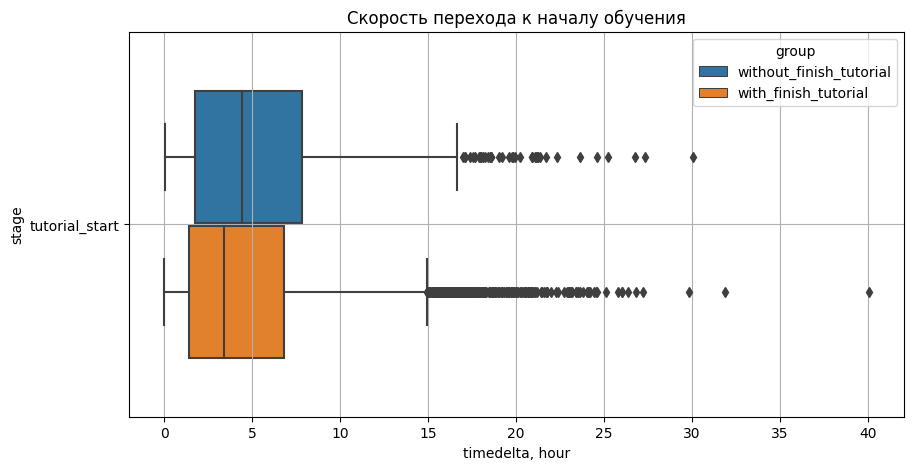

In [21]:
events_without_finish_tutorial_merged_1['group']  = 'without_finish_tutorial'
events_without_finish_tutorial_merged_1['stage']  = 'tutorial_start'
events_without_finish_tutorial_merged_1 = events_without_finish_tutorial_merged_1[
    ['user_id','timedelta','stage','group']]

events_with_finish_tutorial_merged_1['group']  = 'with_finish_tutorial'
events_with_finish_tutorial_merged_1['stage']  = 'tutorial_start'
events_with_finish_tutorial_merged_1 = events_with_finish_tutorial_merged_1[
    ['user_id','timedelta','stage','group']]

merged_tutorial_start_stage = events_without_finish_tutorial_merged_1.merge(
    events_with_finish_tutorial_merged_1,
    on=['user_id','timedelta','stage','group'],
    how='outer')

merged_tutorial_start_stage['timedelta'] = merged_tutorial_start_stage['timedelta'].apply(to_numeric)


fig = plt.figure(figsize=(10, 5))
boxplot = sns.boxplot(
    data=merged_tutorial_start_stage,
    y= 'stage',
    x= 'timedelta',
    hue='group',
    orient='h',  
    width=0.7
)
boxplot.set_title('Скорость перехода к началу обучения');
boxplot.set_xlabel('timedelta, hour');
boxplot.set_ylabel('stage');
boxplot.grid()

На диаграмме видно, что почти все пользователи, не закончившие обучение, на переход от регистрации к началу обучения тратят времени больше, чем пользователи, закончившие обучение. И межквартильный размах рассматриваемых значений для группы пользователей, не закончивших обучение, шире, чем для группы пользователей, закончивших обучение. И то, и другое, помимо прочего, может также означать бОльшую мотивированность пользователей, которые проходят обучение до конца. Мы также видим, что разброс значений показателя скорости прохождения этапов игры для первых 50-ти %%-в пользователей (до медианного значения) меньше, чем - для вторых 50-ти %%-в в обеих группах, что говорит о неравномерности распределения значений показателя для обеих групп. Кроме того, значения скорости прохождения этапов игры второй половиной пользователей содержит довольно много выбросов.

### Cкорость прохождения игры от начала обучения до выбора уровня сложности

In [22]:
# ...пользователями, не окончившими обучение:
events_level_choice_without_finish_tutorial = total_events_df_2018[
    mask_without_finish_tutorial & mask_level_choice].rename(columns={"start_time":"level_choice_time"})

events_without_finish_tutorial_merged_2 = events_tutorial_start_without_finish_tutorial.merge(
    events_level_choice_without_finish_tutorial, on="user_id", how="inner")

events_without_finish_tutorial_merged_2['timedelta'] = events_without_finish_tutorial_merged_2[
    'level_choice_time'] - events_without_finish_tutorial_merged_2['tutorial_start_time']

level_choice_without_finish_tutorial_timedelta_2_mean = events_without_finish_tutorial_merged_2['timedelta'].mean()

print(level_choice_without_finish_tutorial_timedelta_2_mean)

# ...пользователями, окончившими обучение:
events_level_choice_with_finish_tutorial = total_events_df_2018[
    mask_with_finish_tutorial & mask_level_choice].rename(columns={"start_time":"level_choice_time"})

events_with_finish_tutorial_merged_2 = events_tutorial_start_with_finish_tutorial.merge(
    events_level_choice_with_finish_tutorial, on="user_id", how="inner")

events_with_finish_tutorial_merged_2['timedelta'] = events_with_finish_tutorial_merged_2[
    'level_choice_time'] - events_with_finish_tutorial_merged_2['tutorial_start_time']
level_choice_with_finish_tutorial_timedelta_2_mean = events_with_finish_tutorial_merged_2['timedelta'].mean()

print(level_choice_with_finish_tutorial_timedelta_2_mean)

0 days 02:47:28.088829071
0 days 02:23:39.903479536


In [23]:
print(events_without_finish_tutorial_merged_2.describe(include='timedelta'))
print('')
print(events_with_finish_tutorial_merged_2.describe(include='timedelta'))

                       timedelta
count                        743
mean   0 days 02:47:28.088829071
std    0 days 01:42:58.752826263
min              0 days 00:02:05
25%              0 days 01:27:58
50%              0 days 02:42:43
75%       0 days 04:01:45.500000
max              0 days 07:08:18

                       timedelta
count                       7501
mean   0 days 02:23:39.903479536
std    0 days 01:25:03.022412729
min              0 days 00:02:25
25%              0 days 01:12:56
50%              0 days 02:18:04
75%              0 days 03:27:59
max              0 days 06:42:54


Группе пользователей, не закончивших обучение, в среднем требуется на 24 минуты больше времени для перехода от начала обучения к выбору уровня сложности, чем группе, закончившей обучение. Можно предположить, что к числу факторов, повлиявших на сокращение разницы в скорости перехода от предыдущего этапа к последующему для двух групп пользователей, можно отнести уход менее мотивированной и, возможно, менее подготовленной для прохождения игры части пользователей из группы, не закончивших обучение. Мы видим, что эта группа сократилась больше, чем на половину ((1608-743)/1608x100 = 53,8% пользователей, не закончивших обучение, покинули игру до выбора уровня сложности). Среди пользователей, закончивших обучение, этот процент, процент выхода оказался меньше ((10250-7501)/10250x100 = 26,8% пользователей, закончивших обучение, покинули игру до выбора уровня сложности), что еще раз подтверждает бОльшую мотивированность у представителей этой группы. Средние значения показателя скорости близки к медианным, а стандартные отклонения значений показателя для обеих групп по сравнению с предыдущим этапом заметно сокращаются, что говорит о более равномерном, по сравнению с предыдущим этапом, распределении значений показателя, из чего, скорее всего, следует, что группы становятся более "уравновешенными", более однородными, т.к. пользователи, менее мотивированные и менее подготовленные к прохождению игры из нее выходят.

Построим коробчатую диаграмму показателя скорости для двух групп пользователей.

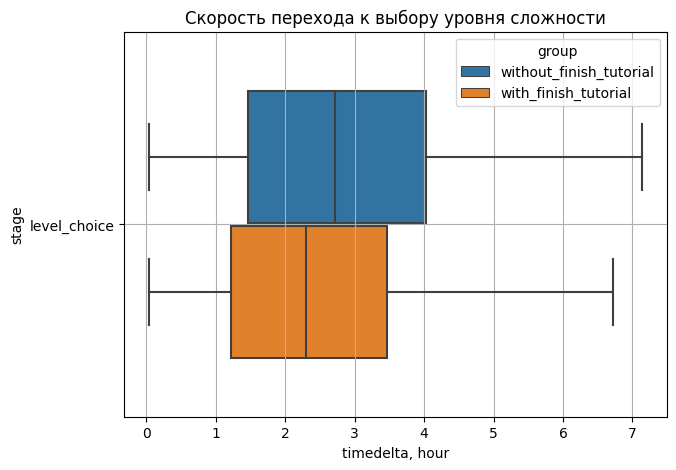

In [24]:
events_without_finish_tutorial_merged_2['group']  = 'without_finish_tutorial'
events_without_finish_tutorial_merged_2['stage']  = 'level_choice'
events_without_finish_tutorial_merged_2 = events_without_finish_tutorial_merged_2[
    ['user_id','timedelta','stage','group']] 

events_with_finish_tutorial_merged_2['group']  = 'with_finish_tutorial'
events_with_finish_tutorial_merged_2['stage']  = 'level_choice'
events_with_finish_tutorial_merged_2 = events_with_finish_tutorial_merged_2[
    ['user_id','timedelta','stage','group']]

merged_level_choice_stage = events_without_finish_tutorial_merged_2.merge(
    events_with_finish_tutorial_merged_2,
    on=['user_id','timedelta','stage','group'],
    how='outer')

merged_level_choice_stage['timedelta'] = merged_level_choice_stage['timedelta'].apply(to_numeric)


fig = plt.figure(figsize=(7, 5))
boxplot = sns.boxplot(
    data=merged_level_choice_stage,
    y='stage',
    x= 'timedelta',
    hue='group',
    orient='h',  
    width=0.7
)
boxplot.set_title('Скорость перехода к выбору уровня сложности');
boxplot.set_xlabel('timedelta, hour');
boxplot.set_ylabel('stage');
boxplot.grid()

В целом картина такая же как и на предыдущем этапе с одной лишь раницей: значения показателя, как отмечалось выше, становятся более "уравновешенными" и однородными, размах значений показателя заметно сокращается.

### Cкорость прохождения игры от выбора уровня сложности до выбора пакета бесплатных вопросов

In [25]:
# ...пользователями, не окончившими обучение:
events_pack_choice_without_finish_tutorial = total_events_df_2018[
    mask_without_finish_tutorial & mask_pack_choice].rename(columns={"start_time":"pack_choice_time"})

events_without_finish_tutorial_merged_3 = events_level_choice_without_finish_tutorial.merge(
    events_pack_choice_without_finish_tutorial, on="user_id", how="inner")

events_without_finish_tutorial_merged_3['timedelta'] = events_without_finish_tutorial_merged_3[
    'pack_choice_time'] - events_without_finish_tutorial_merged_3['level_choice_time']

pack_choice_without_finish_tutorial_timedelta_3_mean = events_without_finish_tutorial_merged_3['timedelta'].mean()

print(pack_choice_without_finish_tutorial_timedelta_3_mean)

# ...пользователями, окончившими обучение:
events_pack_choice_with_finish_tutorial = total_events_df_2018[
    mask_with_finish_tutorial & mask_pack_choice].rename(columns={"start_time":"pack_choice_time"})

events_with_finish_tutorial_merged_3 = events_level_choice_with_finish_tutorial.merge(
    events_pack_choice_with_finish_tutorial, on="user_id", how="inner")

events_with_finish_tutorial_merged_3['timedelta'] = events_with_finish_tutorial_merged_3[
    'pack_choice_time'] - events_with_finish_tutorial_merged_3['level_choice_time']

pack_choice_with_finish_tutorial_timedelta_3_mean = events_with_finish_tutorial_merged_3['timedelta'].mean()

print(pack_choice_with_finish_tutorial_timedelta_3_mean)

0 days 00:05:05.295687885
0 days 00:05:18.146058732


In [26]:
print(events_without_finish_tutorial_merged_3.describe(include='timedelta'))
print('')
print(events_with_finish_tutorial_merged_3.describe(include='timedelta'))

                       timedelta
count                        487
mean   0 days 00:05:05.295687885
std    0 days 00:02:35.198952502
min              0 days 00:00:24
25%              0 days 00:03:04
50%              0 days 00:04:48
75%              0 days 00:06:37
max              0 days 00:15:39

                       timedelta
count                       5176
mean   0 days 00:05:18.146058732
std    0 days 00:02:44.449118501
min              0 days 00:00:19
25%              0 days 00:03:05
50%              0 days 00:04:58
75%              0 days 00:07:11
max              0 days 00:15:48


Этап выбора пакета бесплатных вопросов следует непосредственно сразу после выбора уровня сложности и он очень непродолжительный, от пары десятков секунд до 15-16 минут. Для перехода от выбора уровня сложности до выбора пакета бесплатных вопросов группе пользователей, не закончивших обучение, в среднем требуется на 13 секунд меньше времени, чем пользователям, закончившим обучение. Такую разницу вряд ли можно считать существенной и вряд ли на этой основе мы можем делать какие-то выводы.

### Cкорость прохождения игры от выбора пакета бесплатных вопросов до оплаты

In [27]:
# ...пользователями, не окончившими обучение:
events_purchase_without_finish_tutorial = total_events_df_2018[
    mask_without_finish_tutorial & mask_purchase].rename(columns={"start_time":"purchase_time"})

events_without_finish_tutorial_merged_4 = events_pack_choice_without_finish_tutorial.merge(
    events_purchase_without_finish_tutorial, on="user_id", how="inner")

events_without_finish_tutorial_merged_4['timedelta'] = events_without_finish_tutorial_merged_4[
    'purchase_time'] - events_without_finish_tutorial_merged_4['pack_choice_time']

purchase_without_finish_tutorial_timedelta_4_mean = events_without_finish_tutorial_merged_4['timedelta'].mean()

print(purchase_without_finish_tutorial_timedelta_4_mean)

# ...пользователями, окончившими обучение:
events_purchase_with_finish_tutorial = total_events_df_2018[
    mask_with_finish_tutorial & mask_purchase].rename(columns={"start_time":"purchase_time"})

events_with_finish_tutorial_merged_4 = events_pack_choice_with_finish_tutorial.merge(
    events_purchase_with_finish_tutorial, on="user_id", how="inner")

events_with_finish_tutorial_merged_4['timedelta'] = events_with_finish_tutorial_merged_4[
    'purchase_time'] - events_with_finish_tutorial_merged_4['pack_choice_time']

purchase_with_finish_tutorial_timedelta_4_mean = events_with_finish_tutorial_merged_4['timedelta'].mean()

print(purchase_with_finish_tutorial_timedelta_4_mean)

3 days 21:14:46.908396946
3 days 17:17:59.641326883


In [28]:
print(events_without_finish_tutorial_merged_4.describe(include='timedelta'))
print('')
print(events_with_finish_tutorial_merged_4.describe(include='timedelta'))

                       timedelta
count                        131
mean   3 days 21:14:46.908396946
std    2 days 05:36:49.125505005
min              0 days 05:29:38
25%       1 days 22:35:28.500000
50%              3 days 19:11:35
75%              5 days 13:41:45
max              8 days 15:27:43

                       timedelta
count                       1447
mean   3 days 17:17:59.641326883
std    2 days 04:31:59.804658578
min              0 days 00:44:50
25%       1 days 21:16:05.500000
50%              3 days 12:15:56
75%       5 days 08:53:44.500000
max             10 days 18:33:59


 Мы видим, что для перехода от выбора пакета бесплатных вопросов до покупки пакетов с вопросами группе пользователей, не закончивших обучение, в среднем требуется почти на 4 часа больше времени, чем пользователям, закончившим обучение. Но здесь следует обратить внимание на среднюю продолжительность текущего этапа в целом, и признать, что 4 часа в рамках более чем 3-х с половиной дней (т.е. разница между 93 и 89 часами, соответственно) - это совсем не большой промежуток времени. Разбег в 4 часа в течение одного из (почти) четырех дней может объясняться, например, средним возрастом членов групп и их загруженностью, занятостью. Так, если сравнить, например, младших школьников со старшими или школьников со студентами ВУЗов и т.д., то станет очевидным, что каждая из этих групп, в среднем, живет в своем, отличном от других, режиме. И тогда разницу в 4 часа из более чем 3-х с половиной дней сложно объяснить тем, что именно 3-4-х минутное (а за такое короткое время сложно передать какие-то серьезные навыки, можно лишь показать, как производить те или иные, достаточно примитивные, действия) обучение помогает увеличить скорость прохождения игры. Кроме того, стоит обратить внимание и на размер группы пользователей, не закончивших обучение и купивших пакеты с вопросами. Эта группа состоит всего из 131 пользователя, что не только в 11 раз меньше численности группы пользователей, закончивших обучение и купивших пакеты с вопросами, но и вряд ли делает ее репрезентативной выборкой. Кроме того, мы видим, что группа пользователей, не закончивших обучение, понесла "бОльшие потери" по сравнению со второй группой (в начале "пути" кратность численности групп составляла 6,4 раза, сейчас - 11 раз). Такой, более сильный, отсев из группы пользователей, не закончивших обучение, еще раз подтверждает меньшую мотивированность и подготовленность указанной группы к прохождению игры.
 
 Примечание: Пример с разновозрастными группами - это только пример, который был взят с потолка, но пример, скорее, демонстрирующий несостоятельность нашей гипотезы. И причину различной скорости прохождения различными группами пользователей этапов игры, скорее всего, следует искать не в обучении, а в чем-то другом. Но для этого необходимо иметь больше сведений о пользователях.

Итак, посмотрим, как будут выглядеть на коробчатой диаграмме показатели скорости прохождения этапа от выбора пакета бесплатных вопросов до оплаты для двух групп пользователей.

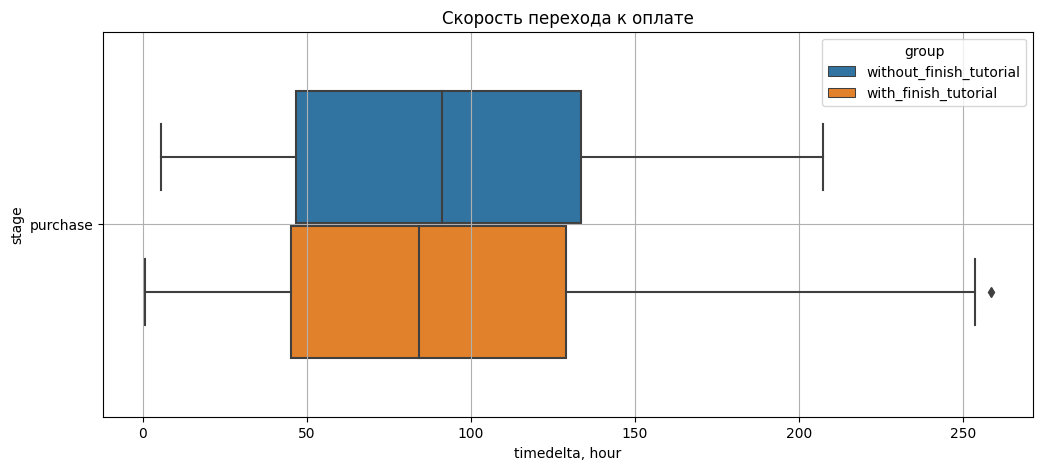

In [29]:
events_without_finish_tutorial_merged_4['group']  = 'without_finish_tutorial'
events_without_finish_tutorial_merged_4['stage']  = 'purchase'
events_without_finish_tutorial_merged_4 = events_without_finish_tutorial_merged_4[
    ['user_id','timedelta','stage','group']]

events_with_finish_tutorial_merged_4['group']  = 'with_finish_tutorial'
events_with_finish_tutorial_merged_4['stage']  = 'purchase'
events_with_finish_tutorial_merged_4 = events_with_finish_tutorial_merged_4[
    ['user_id','timedelta','stage','group']]

merged_purchase_stage = events_without_finish_tutorial_merged_4.merge(
    events_with_finish_tutorial_merged_4,
    on=['user_id','timedelta','stage','group'],
    how='outer')

merged_purchase_stage['timedelta'] = merged_purchase_stage['timedelta'].apply(to_numeric)


fig = plt.figure(figsize=(12, 5))
boxplot = sns.boxplot(
    data=merged_purchase_stage,
    y='stage',
    x= 'timedelta',
    hue='group',
    orient='h',  
    width=0.7
)
boxplot.set_title('Скорость перехода к оплате');
boxplot.set_xlabel('timedelta, hour');
boxplot.set_ylabel('stage');
boxplot.grid()

Полученная картина похожа на все предыдущие, но с той лишь разницей, что на данном этапе разброс значений исследуемого показателя скорости для группы пользователей, закончивших обучение, оказался шире. Скорее всего, это можно объяснить взаимодействием двух факторов: заметно бОльшей продолжительностью данного этапа по сравнению с предыдущими и заметно не большой (до такой степени, что группа перестает быть репрезентативной) численностью группы пользователей, не закончивших обучение. Т.е. вероятность того, что малочисленная группа пользователей покажет меньший разброс значений, чем многочисленная группа, да еще и на относительно продолжительном помежутке времени (что "усиливает результат" большой группы) - большая. 

А теперь посмотрим на полученные данные совокупно. Построим коробчатую и столбчатую диаграммы, отражающие показатели скорости прохождения игры в разрезе всех ее этапов по двум группам пользователей, в отношение которых проводится данное исследование (пользователей, зарегистрированных в 2018 г., начавших, но не закончивших обучение, а также начавших и закончивших обучение).

Собрем все полученные ранее данные о разницах ('timedelta') в скоростях прохождения нашими группами этапов игры в одну таблицу:

In [30]:
# готовим таблицу данных "timedelta" по этапу 'pack_choice' для группы пользователей, не закончивших обучение  
events_without_finish_tutorial_merged_3['group']  = 'without_finish_tutorial'
events_without_finish_tutorial_merged_3['stage']  = 'pack_choice'
events_without_finish_tutorial_merged_3 = events_without_finish_tutorial_merged_3[
    ['user_id','timedelta','stage','group']] 

# готовим таблицу данных "timedelta" по этапу 'pack_choice' для группы пользователей, закончивших обучение  
events_with_finish_tutorial_merged_3['group']  = 'with_finish_tutorial'
events_with_finish_tutorial_merged_3['stage']  = 'pack_choice'
events_with_finish_tutorial_merged_3 = events_with_finish_tutorial_merged_3[
    ['user_id','timedelta','stage','group']] 

# собираем данные по всем этапам для группы пользователей, не закончивших обучение, в одну таблицу
events_without_finish_tutorial_merged = events_without_finish_tutorial_merged_1.merge(
    events_without_finish_tutorial_merged_2, on=['user_id','timedelta','stage','group'],
    how='outer')

events_without_finish_tutorial_merged = events_without_finish_tutorial_merged.merge(
    events_without_finish_tutorial_merged_3, on=['user_id','timedelta','stage','group'],
    how='outer')

events_without_finish_tutorial_merged = events_without_finish_tutorial_merged.merge(
    events_without_finish_tutorial_merged_4, on=['user_id','timedelta','stage','group'],
    how='outer')

# собираем данные по всем этапам для группы пользователей, закончивших обучение, в одну таблицу
events_with_finish_tutorial_merged = events_with_finish_tutorial_merged_1.merge(
    events_with_finish_tutorial_merged_2, on=['user_id','timedelta','stage','group'],
    how='outer')

events_with_finish_tutorial_merged = events_with_finish_tutorial_merged.merge(
    events_with_finish_tutorial_merged_3, on=['user_id','timedelta','stage','group'],
    how='outer')

events_with_finish_tutorial_merged = events_with_finish_tutorial_merged.merge(
    events_with_finish_tutorial_merged_4, on=['user_id','timedelta','stage','group'],
    how='outer')

merged_all_stage = events_without_finish_tutorial_merged.merge(
    events_with_finish_tutorial_merged,
    on=['user_id','timedelta','stage','group'],
    how='outer')

merged_all_stage['timedelta'] = merged_all_stage['timedelta'].apply(to_numeric)

merged_all_stage

,user_id,timedelta,stage,group
0,27840,5.22944,tutorial_start,without_finish_tutorial
1,27856,7.30944,tutorial_start,without_finish_tutorial
2,27857,9.89083,tutorial_start,without_finish_tutorial
3,27859,0.12139,tutorial_start,without_finish_tutorial
4,27865,12.25556,tutorial_start,without_finish_tutorial
...,...,...,...,...
27338,47659,59.98333,purchase,with_finish_tutorial
27339,47687,21.39944,purchase,with_finish_tutorial
27340,47712,34.28472,purchase,with_finish_tutorial
27341,47742,103.75861,purchase,with_finish_tutorial


На основании полученной таблицы данных построим коробчатую и столбчатую диаграммы в разрезе двух исследуемых групп и всех игровых этапов

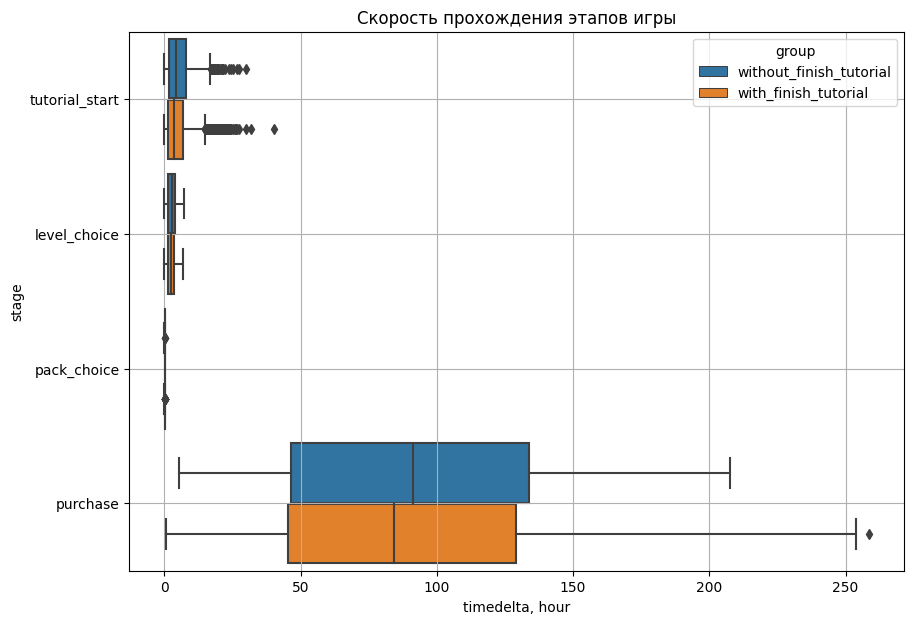

In [31]:
fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=merged_all_stage,
    y='stage',
    x= 'timedelta',
    hue='group',
    orient='h',
    width=0.9
)
boxplot.set_title('Скорость прохождения этапов игры');
boxplot.set_xlabel('timedelta, hour');
boxplot.set_ylabel('stage');
boxplot.grid()

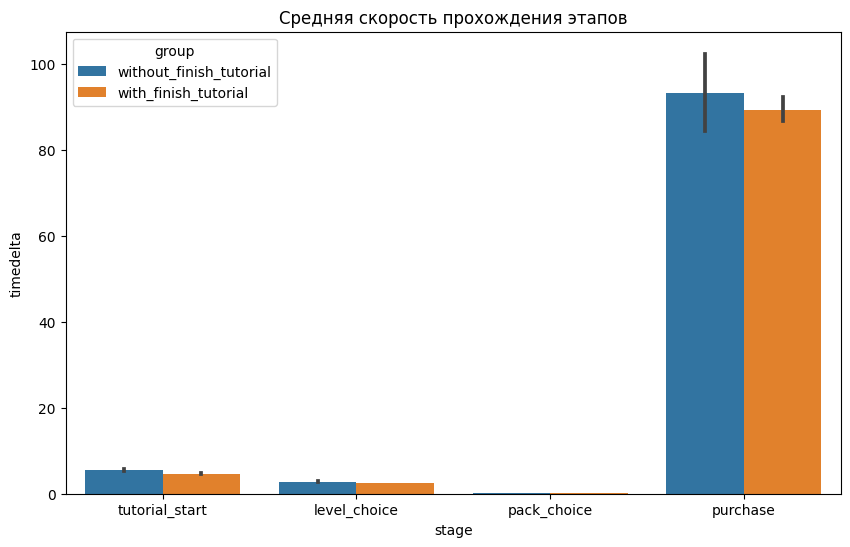

In [32]:
fig = plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=merged_all_stage,
    x='stage',
    y='timedelta',
    hue='group',
)
barplot.set_title('Средняя скорость прохождения этапов');

## Вывод по Гипотезе №1

 Мы видим, что средняя скорость прохождения этапов игры (за исключением этапа 'pack_choice', слишком непродолжительного, чтобы представлять для нас какой-либо интерес, как и было отмечено ранее) для группы пользователей, не закончивших обучение, всегда больше, чем она же для группы пользователей, закончивших обучение. Но мы также видим, что эта разница, скорее, несущественнав в сравнении с продолжительностью этапов: итоговая разница в скорости прохождения игры двумя группами - 5 часов; средняя продолжительность всех этапов игры для одной ('without_finish_tutorial') и другой ('with_finish_tutorial') группы - 101,5 ч. и 96,5 ч., соответственно. Кроме того, анализируя полученную разницу, нам не раз приходилось ставить под сомнение нашу Гипотезу о влиянии обучения на скорость прохождения игры, причем начиная уже с первого этапа, т.е. до начала прохождения обучения. При этом мы не ставим под сомнение ценность обучения как такового. Как мы выяснили ранее, для многих пользователей этап обучения необходим. Мы также не ставим под сомнение и то, что обучение, действительно, позволяет увеличивать скорость выполнения каких-либо задач обученным субъектом. Но в данном конкретном случае, с данной конкретной игрой и на основе данных конкретных сведений о взаимодействии с ней пользователей, подтвердить нашу гипотезу не представлятеся возможным. Без дополнительных сведений о наших пользователях, данная гипотеза, как видим, довольно быстро разбивается, начиная сыпаться уже на первом этапе (до прохождения обучения). Таким образом, этап обучения в игре стоит рассматривать, скорее, как инструмент удержания в ней пользователей, чем как фактор, влияющий на скорость прохождения ее этапов. Отсюда, сравнение указанных выше групп по показателю скорости прохождения ими этапов игры и установление таким образом связи между полученными результатами и обучением не кажется в данном случае верным шагом. 

### *7.2. Гипотеза № 2*

Гипотеза № 2 предполагает, что повторное прохождение обучения положительно влияет на оплату. Верно ли это? Для проверки гипотезы нам небходимо проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь.

Таким образом, для того, чтобы выявить истинность или ложность Гипотезы № 2 нам необходимо найти долю покупок (конверсию в покупки), осуществленных пользователями, которые начинали или завершали обучение только однажды, и долю покупок, осуществленных пользователями, которые начинали или завершали обучение не один раз. А затем сравнить полученные показатели. 

Для начала определим состав групп пользователей, которые подвергнем изучению в рамках данной Гипотезы. 

Разделим группу пользователей, начавших, но не закончивших обучение, на тех, кто начинал обучение только однажды, и тех, кто предпринимал повторные попытки приступить к обучению. 

Также разделим группу пользователей, начавших и закончивших обучение, на тех, кто начинал обучение только однажды, и тех, кто предпринимал повторные попытки приступить к обучению. Кроме того, разделим эту же группу, начавших и закончивших обучение, также и по второму принципу: возьмем за основу для такого деления только те попытки пользователей, которые завершились успешно, т.е. те tutorial_id, для которых в нашей таблице есть записи с двумя событиями: и tutorial_start, и tutorial_finish.

Таким образом, на данном этапе нам необходимо получить три пары списков (наборов,множеств) (далее - списков) пользователей (user_id): 
* первая пара списков будет содержать список пользователей (user_id), не закончивших обучение, для которых в нашей таблице есть записи только с одним событием tutorial_start, и список пользователей (user_id), не закончивших обучение, для которых в нашей таблице есть записи с несколькими событиями tutorial_start;
* вторая пара списков будет содержать список пользователей (user_id), закончивших обучение, для которых в нашей таблице есть записи только с одним событием tutorial_start, и список пользователей (user_id), закончивших обучение, для которых в нашей таблице есть записи с несколькими событиями tutorial_start;
* третяя пара списков будет содержать список пользователей (user_id), закончивших обучение, для которых в нашей таблице есть записи только с одним событием tutorial_finish, и список пользователей (user_id), закончивших обучение, для которых в нашей таблице есть записи с несколькими событиями tutorial_finish.

При этом мы знаем, что были пользователи, предпринимавшие до 9 попыток начать обучение, а также пользователи, успешно завершившие обучение до 9 раз. Но на данном этапе мы не станем делить пользователей на девять списков в каждом из трех наборов, пока удовлетворимся тремя парами (как описано выше). Дальнейшее исследование покажет, будет ли иметь какой-то смысл увеличение дробности наших основных групп (закончивших и незакончивших обучение) до 27-ми (3х9) для дальнейшего изучения.

Может возникнуть вопрос: почему мы не объединим пользователей из первой и второй пары списков и не расчитаем без лишних манипуляций конверсию в оплату пользователей обеих групп, разделив их лишь на тех, кто начинал обучение один раз, и тех, кто начинал обучение не единожды? Дело в том, что, как мы говорили ранее, поведение этих групп определил не только фактор обучения. Изначальное формирование этих групп было обусловлено какими-то другими факторами или фактором (в данном контексте мы не можем это выяснить). И зная о том, что две эти группы изначально несут в себе различия, было бы интересно сравнить их поведение и при проверке текущей Гипотезы.

Приступим. Списки (множества) id пользователей, начавших, но не закончивших, а также начавших и закончивших обучение, у нас уже есть, это: user_id_tutorial_start_wo_finish, user_id_tutorial_finish (см. раздел 7.1 "Гипотеза №1"). Теперь нам нужно получить из этих списков три списка id пользователей с однократной попыткой обучения (завершенной и незавершенной) и три списка id пользователей с многократными попытками обучения (завершенными и незавершенными). Правила формирования узананных списков описаны выше (см.: первая, вторая, третья пары).

In [33]:
# Списки (множества) пользователей, не закончивших обучение (первая пара)

# Формирование списка уникальных id обучений (tutorial_id) (без повторов/дубликатов) для пользователей, не закончивших обучение
tutorial_start_wo_finish_df = total_events_df_2018[(mask_tutorial_start & mask_user_id_tutorial_start_wo_finish)] # дублирует строку из подраздела 7.1
tutorial_start_wo_finish_wo_duplicates_df = tutorial_start_wo_finish_df.sort_values("start_time").drop_duplicates("user_id") # дублирует строку из подраздела 7.1
start_wo_finish_tutorial_wo_duplicates_ids = tutorial_start_wo_finish_wo_duplicates_df["tutorial_id"].unique() # дублирует строку из подраздела 7.1

# Формирование списка повторов/дубликатов id обучений, для пользователей, не закончивших обучение
start_wo_finish_tutorial_with_duplicates_ids = set(tutorial_start_wo_finish_df["tutorial_id"])
start_wo_finish_tutorial_wo_duplicates_ids = set(start_wo_finish_tutorial_wo_duplicates_ids)
duplicates_ids_wo_finish = start_wo_finish_tutorial_with_duplicates_ids.difference(start_wo_finish_tutorial_wo_duplicates_ids)

# Формирование списков id пользователей (user_id) первой пары
user_id_duplicates_start_wo_finish = set(
    total_events_df_2018[total_events_df_2018['tutorial_id'].isin(duplicates_ids_wo_finish)]['user_id'])
user_id_wo_duplicates_start_wo_finish = user_id_tutorial_start_wo_finish.difference(user_id_duplicates_start_wo_finish)

In [34]:
# Списки (множества) пользователей, закончивших обучение (вторая пара: формируется исходя из старта обучения (tutorial_start))

# Формирование списка уникальных id обучений (tutorial_id) (без повторов/дубликатов), а также списка повторов/дубликатов id обучений,
# для пользователей, закончивших обучение
tutorial_start_df = total_events_df_2018[(mask_tutorial_start)]
start_with_duplicates_ids = set(tutorial_start_df["tutorial_id"])
start_with_finish_tutorial_with_duplicates_ids = start_with_duplicates_ids.difference(start_wo_finish_tutorial_with_duplicates_ids)

tutorial_start_with_finish_df = total_events_df_2018[
    total_events_df_2018['tutorial_id'].isin(start_with_finish_tutorial_with_duplicates_ids)]
tutorial_start_with_finish_wo_duplicates_df = tutorial_start_with_finish_df.sort_values("start_time").drop_duplicates("user_id")
start_with_finish_tutorial_wo_duplicates_ids = set(tutorial_start_with_finish_wo_duplicates_df["tutorial_id"].unique())

duplicates_ids_start = start_with_finish_tutorial_with_duplicates_ids.difference(start_with_finish_tutorial_wo_duplicates_ids)

# Формирование списков id пользователей (user_id) для второй пары
user_id_duplicates_start_with_finish_on_start = set(
    total_events_df_2018[total_events_df_2018['tutorial_id'].isin(duplicates_ids_start)]['user_id'])
user_id_wo_duplicates_start_with_finish_on_start = user_id_tutorial_finish.difference(user_id_duplicates_start_with_finish_on_start)

In [35]:
# Списки (множества) пользователей, закончивших обучение (третья пара: формируется исходя из окончания обучения (tutorial_finish))

# Формирование списка уникальных id обучений (tutorial_id) (без повторов/дубликатов) для пользователей, закончивших обучение
tutorial_finish_df = total_events_df_2018[mask_tutorial_finish] # дублирует строку из подраздела 7.1
tutorial_finish_wo_duplicates_df = tutorial_finish_df.sort_values("start_time").drop_duplicates("user_id") # дублирует строку из подраздела 7.1
first_finish_tutorial_wo_duplicates_ids = tutorial_finish_wo_duplicates_df["tutorial_id"].unique() # дублирует строку из подраздела 7.1

# Формирование списка повторов/дубликатов id обучений, для пользователей, не закончивших обучение
first_finish_tutorial_with_duplicates_ids = set(tutorial_finish_df["tutorial_id"])
first_finish_tutorial_wo_duplicates_ids = set(first_finish_tutorial_wo_duplicates_ids)
duplicates_ids_with_finish = first_finish_tutorial_with_duplicates_ids.difference(first_finish_tutorial_wo_duplicates_ids)

# Формирование списков id пользователей (user_id) третьей пары
user_id_duplicates_start_with_finish_on_finish = set(
    total_events_df_2018[total_events_df_2018['tutorial_id'].isin(duplicates_ids_with_finish)]['user_id'])
user_id_wo_duplicates_start_with_finish_on_finish = user_id_tutorial_finish.difference(user_id_duplicates_start_with_finish_on_finish)


In [36]:
print('Длины пар списков пользователей (с повторными обучениями, без повторных обучений, соответственно):')
print('-) первой пары -',
      len(user_id_duplicates_start_wo_finish),',',len(user_id_wo_duplicates_start_wo_finish))
print('-) второй пары -',
      len(user_id_duplicates_start_with_finish_on_start),',',len(user_id_wo_duplicates_start_with_finish_on_start))
print('-) третьей пары -',
      len(user_id_duplicates_start_with_finish_on_finish),',',len(user_id_wo_duplicates_start_with_finish_on_finish))

Длины пар списков пользователей (с повторными обучениями, без повторных обучений, соответственно):
-) первой пары - 53 , 1555
-) второй пары - 2702 , 7548
-) третьей пары - 2235 , 8015


Полученные результаты визуализируем с помощью круговой диаграммы. Но прежде подготовим данные для ее построения.

Добавим в нашу основную таблицу данных 'total_events_df_2018' два признака: 'diagram_tutorial_1', 'diagram_tutorial_2'. И заполним их значениями, позволяющими в дальнейшем собрать данные, для двух вариантов диаграмм, о пользователях групп, состав которых мы определили выше. Т.е. пометим записи БД для пользователей, относящихся к разным группам, обозначениями этих групп. Диаграмма будет представлена в двух вариантах, т.к. группу пользователей, закончивших обучение, мы разбили на тех, кто прошел обучение только однажды, и тех, кто проходил обучения повторно, согласно двум принципам, по началу и по окончанию обучения (т.е. вторая и третья пары списков id пользователей содержат id одних и тех же пользователей). И так как было бы некорректным включать данные об одних и тех же пользователях в одну диаграмму дважды, построим две диаграммы.

In [37]:
def diagram_tutorial_1 (user_id):
    if user_id in user_id_duplicates_start_wo_finish:
        return 'couple-1, gr-1'
    elif user_id in user_id_wo_duplicates_start_wo_finish:
        return 'couple-1, gr-2'
    elif user_id in user_id_duplicates_start_with_finish_on_start:
        return 'couple-2, gr-1'
    elif user_id in user_id_wo_duplicates_start_with_finish_on_start:
        return 'couple-2, gr-2'
    
def diagram_tutorial_2 (user_id):
    if user_id in user_id_duplicates_start_wo_finish:
        return 'couple-1, gr-1'
    elif user_id in user_id_wo_duplicates_start_wo_finish:
        return 'couple-1, gr-2'
    elif user_id in user_id_duplicates_start_with_finish_on_finish:
        return 'couple-3, gr-1'
    elif user_id in user_id_wo_duplicates_start_with_finish_on_finish:
        return 'couple-3, gr-2'    
        
total_events_df_2018['diagram_tutorial_1'] = total_events_df_2018['user_id'].apply(diagram_tutorial_1)
total_events_df_2018['diagram_tutorial_2'] = total_events_df_2018['user_id'].apply(diagram_tutorial_2)

Сформируем таблицы, содержащие данные для диаграмм, посредством наложения соответствующих фильтров на БД.

In [38]:
# маски
mask_tutorial_id_tutorial_start_wo_finish = total_events_df_2018['tutorial_id'].isin(start_wo_finish_tutorial_wo_duplicates_ids)
mask_tutorial_id_tutorial_start_with_finish = total_events_df_2018['tutorial_id'].isin(start_with_finish_tutorial_wo_duplicates_ids)
mask_tutorial_id_first_finish_tutorial = total_events_df_2018['tutorial_id'].isin(first_finish_tutorial_wo_duplicates_ids)

In [39]:
df_for_diagram_1 = total_events_df_2018[(mask_tutorial_id_tutorial_start_wo_finish) |
    (mask_tutorial_start & mask_tutorial_id_tutorial_start_with_finish)]

df_for_diagram_2 = total_events_df_2018[(mask_tutorial_id_tutorial_start_wo_finish) |
    (mask_tutorial_finish & mask_tutorial_id_first_finish_tutorial)]

Сформируем первый вариант диаграммы "Соотношение численности групп, обучающихся пользователей"

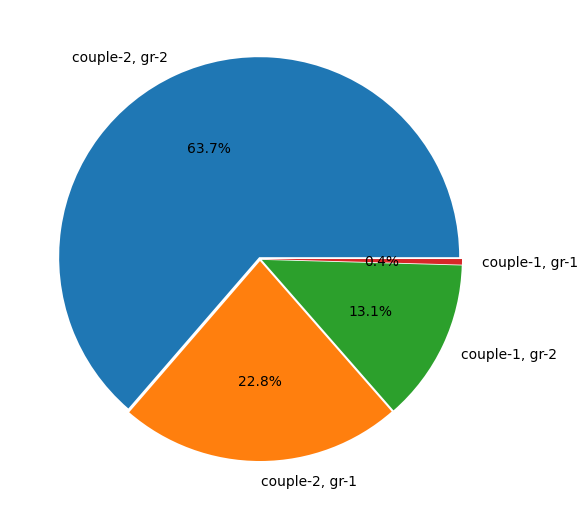

In [40]:
diagram = df_for_diagram_1['diagram_tutorial_1'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    diagram,
    labels=diagram.index,
    autopct='%.1f%%',
    explode = [0.01, 0.01, 0.01, 0.01]
);

Сформируем второй вариант диаграммы "Соотношение численности групп, обучающихся пользователей"

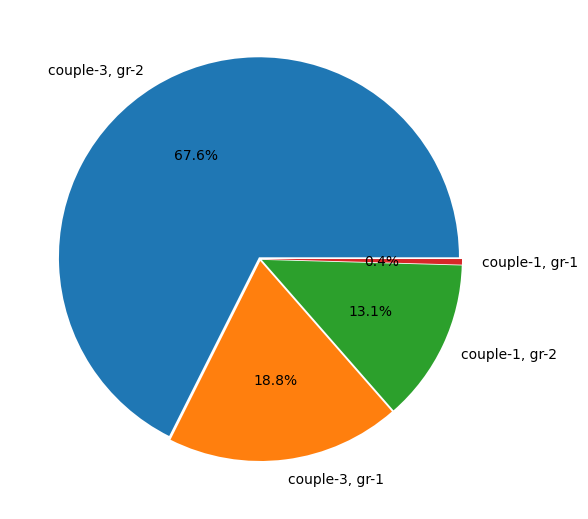

In [41]:
diagram = df_for_diagram_2['diagram_tutorial_2'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    diagram,
    labels=diagram.index,
    autopct='%.1f%%',
    explode = [0.01, 0.01, 0.01, 0.01]
);

Мы видим, что разные подходы к формированию групп пользователей, закончивших обучение, а точнее, к разбивке их на тех, кто прошел обучение однажды, и тех, кто проходил обучение повторно, дают некоторые различия в результатах. Но мы не можем сказать, что имеем дело с двумя принципиально разными картинами. Совсем нет. Процент тех пользователей, которые только однажды прошли обучение до конца, но при этом начинали его не единожды, невелик. Мы видим разницу в процентном соотношении этих групп, при разных подходах, всего примерно в 4-ре, ничего не решающих, %-та (67,6%-63,7%=3,9% или 18,8%-22,8%=-4%, небольшая разница - результат округлений). И вторая группа второй (при одном подходе к формированию групп) и третьей (при другом подходе к формированию групп) пары (пользователи, завершившие обучение, и прошедшие его только однажды), как была численно доминирующей, так такой и осталась.

Три пары списков пользователей получены, диаграммы, отражающие соотношение их численности построены. Далее найдем число пользователей из наших списков, которые совершили покупку.

Сформируем маски фильтров для определения численности групп обучающихся пользователей, которые совершили покупку. И далее найдем численность таких групп пользователей.

In [42]:
# маски
mask_user_id_tutorial_start_wo_finish_with_duplicates = total_events_df_2018['user_id'].isin(user_id_duplicates_start_wo_finish)
mask_user_id_tutorial_start_wo_finish_wo_duplicates = total_events_df_2018['user_id'].isin(user_id_wo_duplicates_start_wo_finish)
mask_user_id_tutorial_start_with_duplicates = total_events_df_2018['user_id'].isin(user_id_duplicates_start_with_finish_on_start)
mask_user_id_tutorial_start_wo_duplicates = total_events_df_2018['user_id'].isin(user_id_wo_duplicates_start_with_finish_on_start)
mask_user_id_tutorial_with_finish_with_duplicates = total_events_df_2018['user_id'].isin(user_id_duplicates_start_with_finish_on_finish)
mask_user_id_tutorial_with_finish_wo_duplicates = total_events_df_2018['user_id'].isin(user_id_wo_duplicates_start_with_finish_on_finish)

In [43]:
df1 = total_events_df_2018[(mask_purchase & mask_user_id_tutorial_start_wo_finish_with_duplicates)]
df2 = total_events_df_2018[(mask_purchase & mask_user_id_tutorial_start_wo_finish_wo_duplicates)]
df3 = total_events_df_2018[(mask_purchase & mask_user_id_tutorial_start_with_duplicates)]
df4 = total_events_df_2018[(mask_purchase & mask_user_id_tutorial_start_wo_duplicates)]
df5 = total_events_df_2018[(mask_purchase & mask_user_id_tutorial_with_finish_with_duplicates)]
df6 = total_events_df_2018[(mask_purchase & mask_user_id_tutorial_with_finish_wo_duplicates)]

print('Длины пар списков пользователей, совершивших покупку (после повторных обучений, без повторных обучений, соответственно):')
print('-) первой пары -',
      len(df1),',',len(df2))
print('-) второй пары -',
      len(df3),',',len(df4))
print('-) третьей пары -',
      len(df5),',',len(df6))

Длины пар списков пользователей, совершивших покупку (после повторных обучений, без повторных обучений, соответственно):
-) первой пары - 7 , 124
-) второй пары - 364 , 1083
-) третьей пары - 304 , 1143


Полученные результаты визуализируем с помощью круговых диаграмм, предварительно также подготовив данные для их построения.

Сформируем таблицы, содержащие данные для диаграмм, посредством наложения соответствующих фильтров на БД.

In [44]:
df_for_diagram_3 = total_events_df_2018[mask_purchase]
df_for_diagram_4 = total_events_df_2018[mask_purchase]

Сформируем первый вариант диаграммы "Соотношение численности групп, обучающихся пользователей, совершивших покупку"

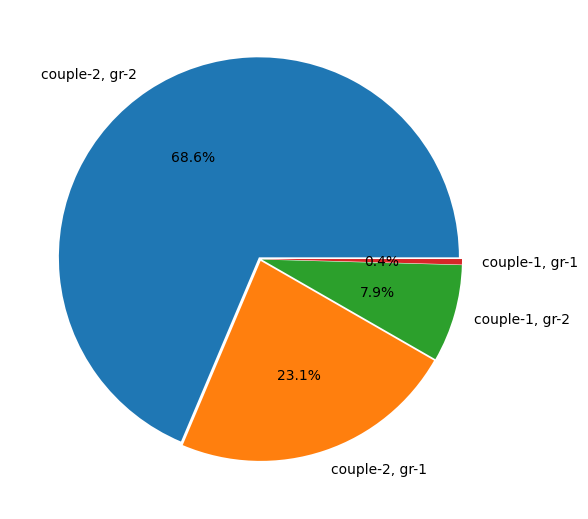

In [45]:
diagram = df_for_diagram_3['diagram_tutorial_1'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    diagram,
    labels=diagram.index,
    autopct='%.1f%%',
    explode = [0.01, 0.01, 0.01, 0.01]
);

Сформируем второй вариант диаграммы "Соотношение численности групп, обучающихся пользователей, совершивших покупку"

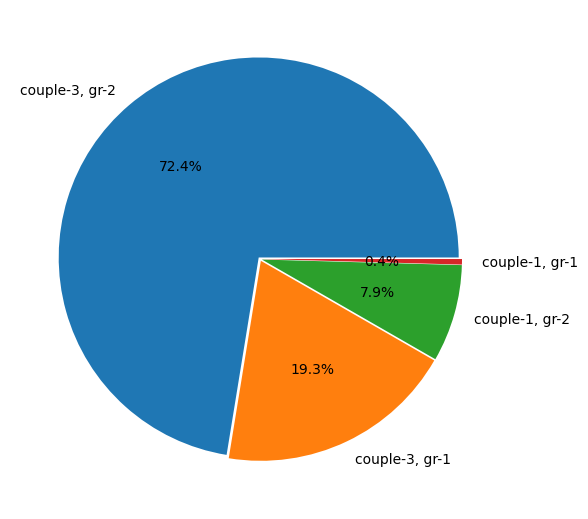

In [46]:
diagram = df_for_diagram_4['diagram_tutorial_2'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    diagram,
    labels=diagram.index,
    autopct='%.1f%%',
    explode = [0.01, 0.01, 0.01, 0.01]
);

Мы видим, что в целом оба варианта диаграмм численности покупающих обучающихся пользователей схожи как между собой, так и с двумя вариантами диаграмм соотношения численности групп пользователей, прошедших обучение. Но обратим внимание на две детали. Во-первых, мы видим, что доля групп второй и третьей пары (т.е. закончивших обучение) на диаграммах покупки по сравнению с диаграммами обучения растет, а первой пары (не закончивших обучение) - снижается, что говорит о том, что конверия в покупку у пользователей, не закончивших обучение, будет хуже, чем у закончивших обучение. Во-вторых, разница между группами второй и третьей пары на диаграммах покупки немного меньше, чем на диаграммах соотношения численности групп пользователей, и составляет 3,8% (72,4%-68,6%=3,8% или 19,3%-23,1%=-3,8%), против примерно 4% для диаграмм соотношения численности групп обучающихся пользователей. Разница совсем незначительная, но она показывает, что конверсия в покупку для второй группы второй пары окажется чуть выше, чем конверсия для второй группы третьей пары из-за чуть меньшего (3,8% против примерно 4%) "перетекания" пользователей (при двух разных подходах к формированию групп) из группы первой в группу вторую между второй и третьей парами для покупающих пользователей по сравнению с обучающимися. Т.е. первое положение, на которое мы обратили внимание, говорит нам о том, что конверсия в покупку у пользователей, закончивших обучение, будет выше, чем конверсия у пользователей, не закончивших обучение, а второе - о том, что среди групп пользователей, закончивших обучение, лидером по конверсии будет группа пользователей, начинавших обучение только однажды и завершивших его (вторая группа второй пары). Далее мы сможем убедиться в этом, рассчитав конверсию в покупку для всех групп. 

Рассчитаем конверсию в покупку для пользователей, проходящих обучение.

In [47]:
conv1 = round(len(df1)/len(user_id_duplicates_start_wo_finish)*100,2)
conv2 = round(len(df2)/len(user_id_wo_duplicates_start_wo_finish)*100,2)
conv3 = round(len(df3)/len(user_id_duplicates_start_with_finish_on_start)*100,2)
conv4 = round(len(df4)/len(user_id_wo_duplicates_start_with_finish_on_start)*100,2)
conv5 = round(len(df5)/len(user_id_duplicates_start_with_finish_on_finish)*100,2)
conv6 = round(len(df6)/len(user_id_wo_duplicates_start_with_finish_on_finish)*100,2)

print('Конверсия первой пары пользователей',
      conv1,'%,',conv2,'%')
print('Конверсия второй пары пользователей',
      conv3,'%,',conv4,'%')
print('Конверсия третьей пары пользователей',
      conv5,'%,',conv6,'%')

Конверсия первой пары пользователей 13.21 %, 7.97 %
Конверсия второй пары пользователей 13.47 %, 14.35 %
Конверсия третьей пары пользователей 13.6 %, 14.26 %


Как видим, самая высокая конверсия (14,35%) в группе пользователей, прошедших обучение до конца, сделавших это только однажды и с первой попытки. Похоже на то, что это самая собранная, самая мотивированная и самая подготовленная для прохождения игры группа. Самая низкая конверсия (7,97%) в группе пользователей, не закончивших обучение и сделавших только одну попытку его начать. А это похоже на шаблон поведения наименее мотивированной и наименее подготовленной группы пользователей. Похоже, что эти пользователи не очень-то сильно были заинтересованы в продолждении игры, они не только не прошли обучение до конца, они даже не предприняли повторных попыток его начать, при этом отсев в этой группе оказался самым высоким, что подтверждается самой низкой конверсией. Таким образом, большой отсев и невысокая заинтересованность пользователей подтверждают их низкую мотивированность и низкую подготовленность к прохождению игры.

Что касается остальных групп пользователей, нельзя сказать, что конверсия в этих группах сильно отличается от, так называемого, лидера (это хорошо будет видно на столбчатых диаграммах далее). Самый большой отрыв от лидера среди этих групп, в 1,14 % (14,36% - 13,21%), наблюдается в группе пользователей, не закончивших, как и группа-аутсайдер (по конверсии), обучение, но совершивних не одну попытку его начать (такая насточивость говорит нам о бОльшей мотивированности пользователей этой группы по сравнению с группой-аутсайдером). При этом ближе всего к группе-лидеру по конверсии находится группа пользователей (14,26%), прошедших, также как и пользователи из группы-лидера, обучение до конца, и сделавших это также только однажды, но не всегда с первой попытки (в группе, о которой идет речь, есть пользователи, которые до первой и едиственной успешной попытки пройти обучение до конца начинали его не один раз).

Таким образом, мы видим, что самая высокая конверсия в группах пользователей, прошедших обучение до конца и сделавших это только однажды (14,35%, 14,26%) (по большей части, пользователи в этих двух группах одни и те же (см. выше два разных подхода к формированию групп)). "Обучение до конца и однажды" - говорит нам о более высокой мотивированности и подготовленности пользователей из этих групп. А самая низкая конверсия - в группах, не закончивших обучение (13,21%, 7,97%), менее подготовленных и менее мотивированных, судя по результатам. Кроме того, мы видим, что все группы, в которых предпринималась не одна попытка обучения, включая группу с повторными успешными обучениями, имеют конверсию ниже (13,21%, 13,47%, 13,6%), чем в группах, где пройдено "обучение до конца и однажды" (14,35%, 14,26%). При этом, не будем забывать, что группы, не попавшие по показателю конверсии в оплату в лидеры, лидеру уступают незначительно (исключение - группа-аутсайдер). Рассмотрим это далее на столбчатых диаграммах.

На основании полученных результатов сформируем две таблицы с данными о конверсии пользователей в покупку. А затем визуализируем их в двух столбчатых диаграммах.

In [48]:
df_for_diagram_5 = pd.DataFrame(
    data = [['Пара 1, Группа 1',conv1],['Пара 1, Группа 2',conv2],['Пара 2, Группа 1',conv3],['Пара 2, Группа 2',conv4]],
    columns = ['group','conversion'],
    index = ['couple-1, gr-1','couple-1, gr-2','couple-2, gr-1','couple-2, gr-2'])

df_for_diagram_6 = pd.DataFrame(
    data = [['Пара 1, Группа 1',conv1],['Пара 1, Группа 2',conv2],['Пара 3, Группа 1',conv5],['Пара 3, Группа 2',conv6]],
    columns = ['group','conversion'],
    index = ['couple-1, gr-1','couple-1, gr-2','couple-3, gr-1','couple-3, gr-2'])

Сформируем первый вариант диаграммы "Конверсия в покупку"

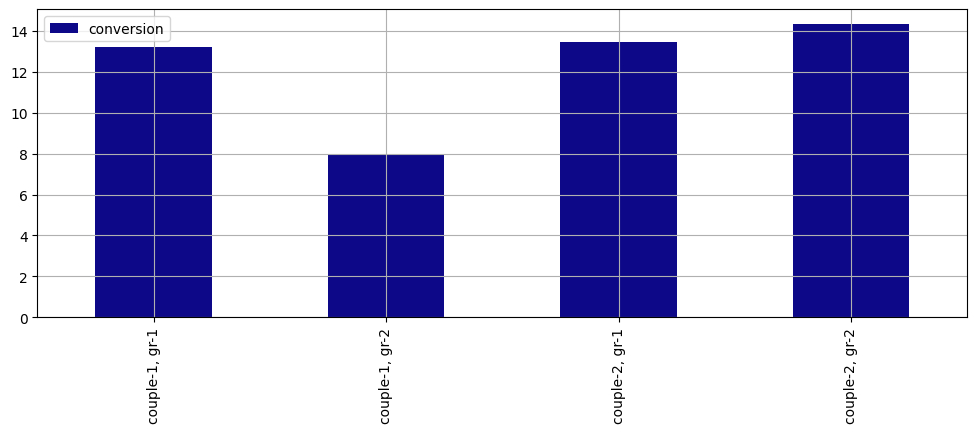

In [49]:
df_for_diagram_5.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='plasma'
);

Сформируем второй вариант диаграммы "Конверсия в покупку"

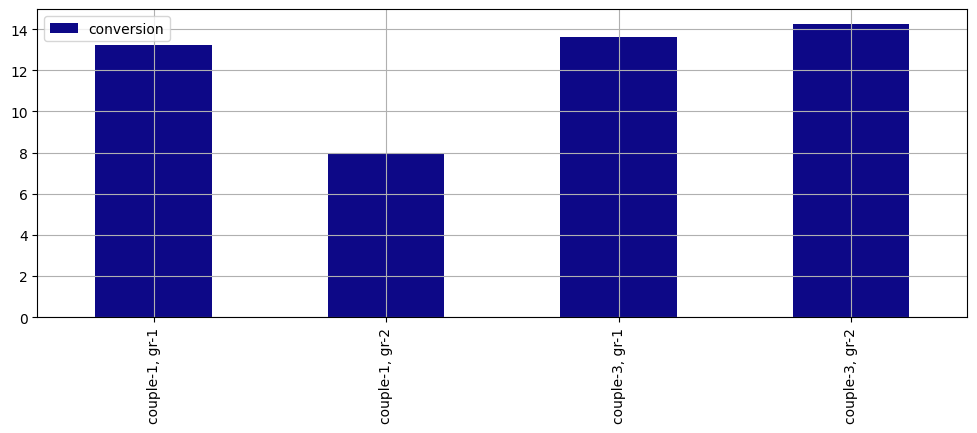

In [50]:
df_for_diagram_6.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='plasma'
);

На примере столбчатых диаграмм мы можем убедиться в том, что наше утверждение о том, что группы, не попавшие по показателю конверсии в оплату в лидеры, лидеру уступают незначительно (исключение - группа-аутсайдер), подтверждается и визуализацией полученных результатов.

## Вывод по Гипотезе №2

Как видим, мы не можем говорить о том, что повторное прохождение обучения само по себе является решающим и предопределяющим фактором для установления уровня конверсии в оплату. Мы не можем говорить о том, что, вне зависимости от прочих факторов, повторное обучение само по себе выводит группу пользователей, которые были в этом замечены :), на более высокую конверсию в покуку по сравнению с группой пользователей, которые повторного обучения не проходили. Такая прямая зависимость между повторным прохождением обучения и конверсией в покупку отсутствует. Это подтверждают полученные нами результаты.

Как мы выяснили ранее, группы пользователей с самой высокой конверсией в покупку - это группы пользователей, прошедшие "обучение до конца и однажды", они же в среднем самые мотивированные и самые подготовленные для прохождения нашей игры. И, судя по всему, они просто не нуждаются в повторных обучениях для поддержания (в среднем на более высоком уровне по сравнению с другими группами) своего интереса к игре. Процент тех, кто остается в игре до конца, в этих группах, как мы видим, самый высокий: конверсия в покупку в них выше, чем в остальных группах. И, как мы видим, не благодаря повторному обучению.

НО! Мы также не можем утверждать, что повторное прохождение обучения не влияет, и при том не влияет положительно, на конверсию в оплату. Пользователь, который выбирает для себя повторное обучение, с большой долей вероятности, делает это по необходимости, т.е. без повторного обучения его продвижение в игре было бы затруднительным, если было бы вообще возможным. Таким образом, вероятность того, что такой пользователь не смог бы или не захотел бы дальше оставаться в игре, без повторного обучения увеличилась бы. А следовательно, увеличилась бы и вероятность снижения конверсии в покупку. Т.е повторное обучение все-таки влияет и влияет положительно на конверсию в оплату через удержание пользователей в игре и через увеличение, таким образом, числа потенциальных покупателей. Но "работает" это только с определенными пользователями, а именно: менее подготовленными для прохождения игры. Таким образом, фактор повторного обучения имеет значение и играет свою положительную роль только совместно с другим или другими факторами.

Такую же роль обучение играет и в случае с пользователями, однажды успешно прошедшими обучение, т.е. играет на удержание пользователей в игре, а через это влияет и на конверсию. Кроме того, и в этом случае, в случае с пользователями, однажды успешно прошедшими обучение, обучение играет свою положительную роль только совместно с другим или другими факторами, например, с их более сильной мотивацией, которую обучение призвано усилить.

Исходя из установленного ранее факта, что "группы, не попавшие по показателю конверсии в оплату в лидеры, лидеру уступают незначительно (исключение - группа-аутсайдер)", можно заключить, что само по себе обучение не влияет на оплату, оно лишь усиливает другие факторы, "работая" на удержание пользователей в игре, а через это влияет и на конверсию в оплату.

Таким образом, нашу Гипотезу о том, что повторное прохождение обучения положительно влияет на оплату, можно отчасти считать верным, а утверждение о том, что успешное обучение САМО ПО СЕБЕ влияет на оплату - неверным (см. абз. выше, а также - число отсеявшихся после успешно пройденного обучения пользователей (п. 7.1 "Гипотеза №1")).

### *7.3. Гипотеза № 3*

Гипотеза № 3 заключается в разрешении следующего вопроса: если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?

Для ответа на поставленный вопрос достаточно вернуться к расчетам скорости прохождения игры от начала обучения до выбора уровня сложности, приведенным в п. 7.1 для проверки Гипотезы № 1. Если бы результаты метода describe, примененного к колонкам timedelta таблиц: events_without_finish_tutorial_merged_2, events_with_finish_tutorial_merged_2, содержащих сведения о скорости (таймдельте) перехода от начала обучения к выбору уровня сложности, показали бы в графах минимального значения (min) значение отрицательное, тогда ответ на текущий вопрос был бы положительным.

In [51]:
print(events_without_finish_tutorial_merged_2.describe(include='timedelta'))
print('')
print(events_with_finish_tutorial_merged_2.describe(include='timedelta'))

                       timedelta
count                        743
mean   0 days 02:47:28.088829071
std    0 days 01:42:58.752826263
min              0 days 00:02:05
25%              0 days 01:27:58
50%              0 days 02:42:43
75%       0 days 04:01:45.500000
max              0 days 07:08:18

                       timedelta
count                       7501
mean   0 days 02:23:39.903479536
std    0 days 01:25:03.022412729
min              0 days 00:02:25
25%              0 days 01:12:56
50%              0 days 02:18:04
75%              0 days 03:27:59
max              0 days 06:42:54


Но так как в графах минимального значения (min) отрицательных значений мы не наблюдаем, из вышесказанного вытекает следующий вывод.

## Вывод по Гипотезе №3

Если пользователь сначала выбирает сложность обучения, то проходить потом обучение он не будет. По крайней мере, полученные нами сведения о пользователях, зарегистрированных в игре в 2018 г., таких данных не содержат.

___________________________________________________________________

## РЕКОМЕНДАЦИИ для повышения конверсии в покупку:
* возможно, стоит попробовать расширить горизонт тем, представленных в пакетах с вопросами, а также увеличить градацию уровней сложности, так чтобы удовлетворить интересы более широкого круга пользовательской аудитории; 
* специалистам по маркетингу стоит обратить внимание на качество проведенных мероприятий по таргетированию (см. число пользователей, отсеявшихся после регистрации (см. user_paths, п. 7.1 "Гипотеза № 1")).

___________________________________________________________________

## P.S.

Возможно, было бы полезным также изучить конверсию в покупки групп пользователей на разных этапах прохождения игры, выяснить какова динамика ухода пользователей из игры, на каких этапах уходит больший процент пользователей, попытаться понять, почему пользователи не доходят до целевого этапа покупки, по какой причине/причинам они отсеиваются (см. user_paths, п. 7.1 "Гипотеза № 1")